Mohammad Hossein Eslami 401105537


# k-mer counting: canonical k-mers, reverse complements, and fast rolling implementation

This notebook collects explanations and **full, working code** for the "k-mer and its reverse complement frequency" problem.
It contains:

- Definitions and intuition.
- Mathematical formulas for canonical k-mer counts (including palindromes).
- A **simple** (easy-to-read) canonical k-mer counter (string-based).
- A **fast rolling** 2-bit encoded canonical k-mer counter (O(1) per step).
- Options: strand-aware vs strand-agnostic (canonical), skip ambiguous bases (`N`), palindromes handling.
- Utilities: FASTA reader, example runs and tests, a tiny de Bruijn graph builder that uses canonical k-mers.
- Example outputs and a small demo dataset.

You can run the notebook cells or download the notebook file.



## Combinatorics recap

- Total distinct k-mers: $4^k$.
- Palindromic k-mers (equal to their reverse complement):
  - If k is odd: 0 palindromes.
  - If k is even: $4^{(k/2)}$ palindromes.
- Number of canonical representatives (one per {k-mer, RC} pair):

canonical_count = $\frac{(4^k + pkmers)}{2}$


In [1]:

# --- Utilities: reverse complement, canonicalization, FASTA reader, formula functions ---

COMP = str.maketrans('ACGTacgt', 'TGCAtgca')

def rev_comp(s: str) -> str:
    """Return reverse complement of DNA string s (assumes A,C,G,T,N)."""
    return s.translate(COMP)[::-1]

def canonical_kmer(s: str) -> str:
    """Return canonical representative (lexicographically smaller of s and its RC)."""
    rc = rev_comp(s)
    return s if s <= rc else rc

def is_palindrome_kmer(s: str) -> bool:
    return s == rev_comp(s)

def canonical_space_size(k: int) -> int:
    total = 4**k
    pal = 0 if (k % 2 == 1) else 4**(k//2)
    return (total + pal) // 2

def read_fasta(fp):
    """Generator: yields (header, sequence) pairs from a FASTA file-like object or path."""
    if isinstance(fp, str):
        f = open(fp, 'r')
        close_after = True
    else:
        f = fp
        close_after = False

    header = None
    seq_chunks = []
    for line in f:
        line = line.rstrip('\n')
        if not line:
            continue
        if line.startswith('>'):
            if header is not None:
                yield header, ''.join(seq_chunks)
            header = line[1:].strip()
            seq_chunks = []
        else:
            seq_chunks.append(line.strip())
    if header is not None:
        yield header, ''.join(seq_chunks)
    if close_after:
        f.close()


In [3]:

# --- Simple canonical counter (string-based) ---
from collections import defaultdict

def count_kmers_simple(seq: str, k: int, strand_aware: bool=False, skip_ambiguous: bool=True):
    """Count k-mers in sequence `seq`.
    - strand_aware=False (default): canonicalize k-mer with its reverse complement (merge counts).
    - strand_aware=True: keep separate counts for k-mer and its RC.
    - skip_ambiguous: skip any k-mer containing characters outside ACGT (e.g. 'N').
    Returns a dict mapping k-mer (or canonical k-mer) -> count.
    """
    seq = seq.upper()
    counts = defaultdict(int)
    n = len(seq)
    for i in range(n - k + 1):
        kmer = seq[i:i+k]
        if skip_ambiguous and any(ch not in 'ACGT' for ch in kmer):
            continue
        if strand_aware:
            counts[kmer] += 1
        else:
            key = canonical_kmer(kmer)
            counts[key] += 1
    return dict(counts)


In [4]:

# --- Fast rolling 2-bit encoded canonical counter (O(1) per k-mer step) ---
# Mapping: A->0, C->1, G->2, T->3 (2 bits each)
BASE2 = {'A':0, 'C':1, 'G':2, 'T':3}
COMP2 = {0:3, 1:2, 2:1, 3:0}  # complement in 2-bit space (A<->T, C<->G)

def int_to_kmer(code: int, k: int) -> str:
    """Convert integer code (2-bit per base) to k-mer string (forward orientation)"""
    res = []
    for i in range(k-1, -1, -1):
        bits = (code >> (2*i)) & 3
        res.append('ACGT'[bits])
    return ''.join(res)

def count_kmers_rolling(seq: str, k: int, strand_aware: bool=False, skip_ambiguous: bool=True):
    """Rolling implementation using 2-bit encoding.
    Returns dict mapping canonical k-mer string (or k-mer if strand_aware) -> count.
    This returns strings as keys for user-friendliness, but uses integers internally for speed.
    """
    seq = seq.upper()
    n = len(seq)
    if k <= 0 or n < k:
        return {}
    mask = (1 << (2*k)) - 1
    fwd = 0  # integer code for forward k-mer
    rc = 0   # integer code for reverse complement of the k-mer (as if reading reversed)
    counts = {}
    valid = 0  # number of consecutive valid bases seen for rolling window

    for i, ch in enumerate(seq):
        if ch not in BASE2:
            # ambiguous base -> reset rolling window
            valid = 0
            fwd = 0
            rc = 0
            continue
        val = BASE2[ch]
        # update forward: append low-order bits
        fwd = ((fwd << 2) | val) & mask
        # update reverse-complement: we prepend complement(val) at the high bits position
        rc = (rc >> 2) | (COMP2[val] << (2*(k-1)))
        valid += 1
        if valid >= k:
            # decode both integers to strings if needed, or choose canonical by integer min
            if strand_aware:
                kmer = int_to_kmer(fwd, k)
                counts[kmer] = counts.get(kmer, 0) + 1
            else:
                # choose canonical by integer comparison: but note rc currently is code for RC(kmer)
                # We must compare the integer codes corresponding to the same orientation.
                # fwd is forward code; rc is reverse-complement code **in forward orientation**,
                # so we can directly min() them to pick canonical integer.
                can_int = fwd if fwd <= rc else rc
                can_kmer = int_to_kmer(can_int, k)
                counts[can_kmer] = counts.get(can_kmer, 0) + 1
    return counts


In [5]:

# --- Tiny de Bruijn graph builder (using canonical k-mers as nodes) ---
from collections import defaultdict

def build_debruijn_from_counts(counts: dict, k: int):
    """Build a de Bruijn graph as adjacency dict from canonical k-mer counts.
    Nodes are canonical (k-1)-mers. Edges are canonical k-mers linking prefix->suffix.
    Returns adjacency: node -> dict(neighbor -> weight)
    """
    adj = defaultdict(lambda: defaultdict(int))
    for can_kmer, w in counts.items():
        # Note: counts may already be canonical k-mers (k length).
        if len(can_kmer) != k:
            continue
        prefix = can_kmer[:-1]
        suffix = can_kmer[1:]
        adj[prefix][suffix] += w
    return {u: dict(v) for u,v in adj.items()}


In [6]:

# --- Demo: small examples & tests ---
if __name__ == '__main__':
    seq = 'ATGCGCAT'
    k = 3
    print('Sequence:', seq)
    print('\nSimple canonical counts:')
    print(count_kmers_simple(seq, k, strand_aware=False))
    print('\nSimple strand-aware counts:')
    print(count_kmers_simple(seq, k, strand_aware=True))
    print('\nRolling canonical counts:')
    print(count_kmers_rolling(seq, k, strand_aware=False))
    print('\nRolling strand-aware counts:')
    print(count_kmers_rolling(seq, k, strand_aware=True))
    print('\nCanonical space sizes for k=1..6:')
    for kk in range(1,7):
        print(kk, canonical_space_size(kk))


Sequence: ATGCGCAT

Simple canonical counts:
{'ATG': 2, 'GCA': 2, 'CGC': 2}

Simple strand-aware counts:
{'ATG': 1, 'TGC': 1, 'GCG': 1, 'CGC': 1, 'GCA': 1, 'CAT': 1}

Rolling canonical counts:
{'ATG': 2, 'GCA': 2, 'CGC': 2}

Rolling strand-aware counts:
{'ATG': 1, 'TGC': 1, 'GCG': 1, 'CGC': 1, 'GCA': 1, 'CAT': 1}

Canonical space sizes for k=1..6:
1 2
2 10
3 32
4 136
5 512
6 2080


## Notes, parameters and caveats

- We used a simple Hamming-distance-based approximate matcher (allowing mismatches) for DnaA-box detection. For increased sensitivity use a PWM or FIMO-style search.
- The scoring function is heuristic: motif density weighted with proximity to the cumulative GC skew global minimum. You can tune weights and window sizes for your dataset.
- E. coli oriC is typically ~245 bp with multiple DnaA boxes (R1-R5 etc.) and an AT-rich DUE. Our window sizes (1-3 kb) aim to capture clusters of boxes.

# E. coli oriC detection - DnaA-box motif search, sliding-window density, and GC-skew

## Biological background (brief)

In E. coli, the origin of replication (oriC) contains multiple DnaA-box 9-mer motifs (consensus often written 'TTATCCACA'), an AT-rich DUE, and nearby regulatory sites. We search for clusters of DnaA-box matches and corroborate them with cumulative GC-skew minima to produce candidate oriC windows.

In [7]:

# E. coli extension: motif matching, sliding-window density, GC skew, scoring, FASTA reader

from collections import defaultdict
import math

# exact reverse complement helper
COMP = str.maketrans('ACGTacgt', 'TGCAtgca')

def rev_comp(s: str) -> str:
    return s.translate(COMP)[::-1]

# Hamming distance
def hamming(s: str, t: str) -> int:
    assert len(s) == len(t)
    return sum(ch1 != ch2 for ch1, ch2 in zip(s, t))

# find exact motif positions
def find_exact_motif_positions(seq: str, motif: str):
    seq = seq.upper()
    motif = motif.upper()
    positions = []
    m = len(motif)
    for i in range(len(seq) - m + 1):
        if seq[i:i+m] == motif:
            positions.append(i)
    return positions

# find approximate motif positions (allow up to max_mismatches)
def find_approx_motif_positions(seq: str, motif: str, max_mismatches: int=1):
    seq = seq.upper()
    motif = motif.upper()
    positions = []
    m = len(motif)
    for i in range(len(seq) - m + 1):
        window = seq[i:i+m]
        if any(ch not in 'ACGT' for ch in window):
            continue
        if hamming(window, motif) <= max_mismatches:
            positions.append(i)
    return positions

# sliding-window density of motif matches (counts per window)
def sliding_window_density(seq: str, motif: str, window_size: int=1000, step: int=100, max_mismatches:int=1):
    seq = seq.upper()
    positions = find_approx_motif_positions(seq, motif, max_mismatches=max_mismatches)
    # build prefix sum of motif hits
    hit = [0] * (len(seq) + 1)
    m = len(motif)
    for p in positions:
        # mark hit at p (we count motif by start position)
        if 0 <= p < len(seq):
            hit[p+1] += 1
    # prefix sum
    for i in range(1, len(hit)):
        hit[i] += hit[i-1]
    windows = []
    if len(seq) < window_size:
        # single window covering whole sequence
        count = hit[len(seq)] - hit[0]
        windows.append((0, len(seq), count))
        return windows
    for start in range(0, max(1, len(seq) - window_size + 1), step):
        end = start + window_size
        count = hit[min(end, len(seq))] - hit[start]
        windows.append((start, end, count))
    return windows

# GC skew calculation
def gc_skew_array(seq: str):
    seq = seq.upper()
    arr = []
    for ch in seq:
        if ch == 'G':
            arr.append(1)
        elif ch == 'C':
            arr.append(-1)
        else:
            arr.append(0)
    return arr

# cumulative GC skew (per-base cumulative sum of G-C)
def cumulative_gc_skew(seq: str):
    arr = gc_skew_array(seq)
    cum = [0]
    s = 0
    for v in arr:
        s += v
        cum.append(s)
    # cum is length n+1; position i corresponds to sum up to base i-1
    return cum

# Combined scoring: motif density (normalized) + proximity to cumulative minimum
def score_windows_by_motif_and_skew(seq: str, motif: str, window_size: int=2000, step: int=200, max_mismatches:int=1):
    seq = seq.upper()
    windows = sliding_window_density(seq, motif, window_size=window_size, step=step, max_mismatches=max_mismatches)
    cum = cumulative_gc_skew(seq)
    if len(cum) == 0:
        return []
    # find global minima index
    min_idx = min(range(len(cum)), key=lambda i: cum[i])
    scored = []
    max_count = max((w[2] for w in windows), default=1)
    for start, end, count in windows:
        center = (start + end)//2
        # motif score normalized
        motif_score = count / max_count if max_count > 0 else 0.0
        # proximity score to GC skew minimum (smaller distance -> higher score)
        dist = abs(center - min_idx)
        prox_score = 1 / (1 + math.log(1 + dist)) if dist > 0 else 1.0
        total = 0.6 * motif_score + 0.4 * prox_score
        scored.append({'start': start, 'end': end, 'count': count, 'motif_score': motif_score, 'prox_score': prox_score, 'total': total})
    scored_sorted = sorted(scored, key=lambda x: x['total'], reverse=True)
    return scored_sorted

# FASTA reader (included here)
def read_fasta(fp):
    if isinstance(fp, str):
        f = open(fp, 'r')
        close_after = True
    else:
        f = fp
        close_after = False
    header = None
    seq_chunks = []
    for line in f:
        line = line.rstrip('\n')
        if not line:
            continue
        if line.startswith('>'):
            if header is not None:
                yield header, ''.join(seq_chunks)
            header = line[1:].strip()
            seq_chunks = []
        else:
            seq_chunks.append(line.strip())
    if header is not None:
        yield header, ''.join(seq_chunks)
    if close_after:
        f.close()


## Example usage (run these cells in the notebook)

1. Set parameters for E. coli (DnaA-box motif & FASTA path) and load the sequence:

In [8]:
motif = 'TTATCCACA'  # canonical DnaA-box; you can allow mismatches
fasta_path = '/content/sequence.fasta'  # replace with your file
header, seq = next(read_fasta(fasta_path))
print('Loaded', header, 'len=', len(seq))

Loaded AP022815.1 Escherichia coli JE86-ST05 DNA, complete genome len= 5327513


2. Compute scored windows and show top candidates:

In [9]:
scored = score_windows_by_motif_and_skew(seq, motif, window_size=2000, step=200, max_mismatches=1)
for s in scored[:10]:
    print(s)


{'start': 4589800, 'end': 4591800, 'count': 4, 'motif_score': 1.0, 'prox_score': 0.07859516195241725, 'total': 0.6314380647809669}
{'start': 4590000, 'end': 4592000, 'count': 4, 'motif_score': 1.0, 'prox_score': 0.07858516209021259, 'total': 0.631434064836085}
{'start': 5016400, 'end': 5018400, 'count': 4, 'motif_score': 1.0, 'prox_score': 0.0703347252728311, 'total': 0.6281338901091325}
{'start': 5016600, 'end': 5018600, 'count': 4, 'motif_score': 1.0, 'prox_score': 0.0703329268444081, 'total': 0.6281331707377632}
{'start': 5206600, 'end': 5208600, 'count': 4, 'motif_score': 1.0, 'prox_score': 0.06889559425844145, 'total': 0.6275582377033766}
{'start': 5206800, 'end': 5208800, 'count': 4, 'motif_score': 1.0, 'prox_score': 0.0688943119884823, 'total': 0.6275577247953928}
{'start': 5207000, 'end': 5209000, 'count': 4, 'motif_score': 1.0, 'prox_score': 0.068893030112545, 'total': 0.627557212045018}
{'start': 5207200, 'end': 5209200, 'count': 4, 'motif_score': 1.0, 'prox_score': 0.0688917

3. Plot cumulative GC skew and motif density (requires matplotlib):

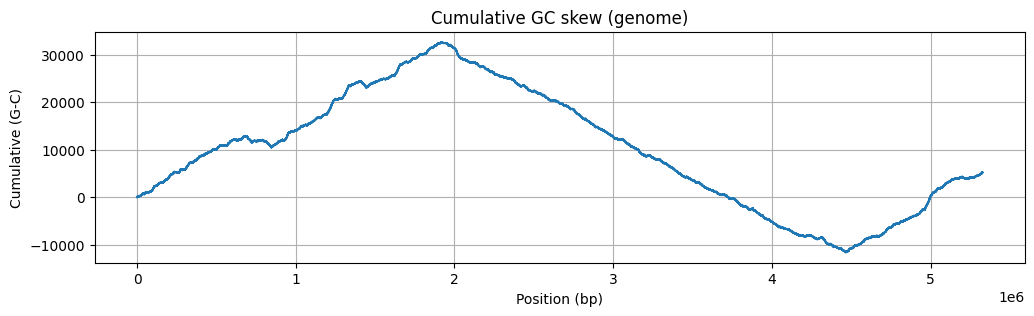

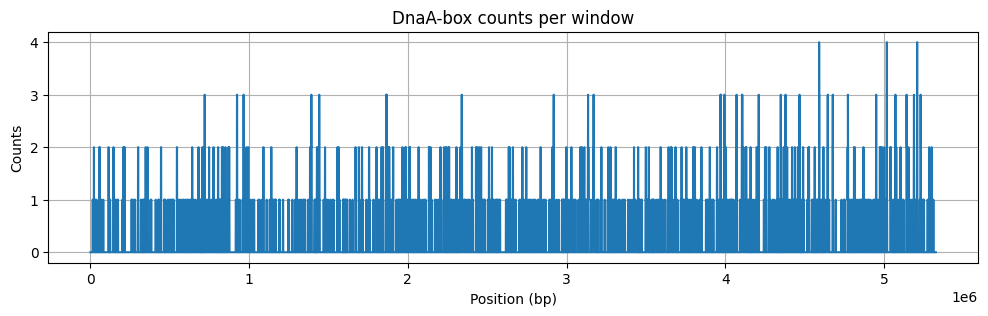

In [10]:
import matplotlib.pyplot as plt
cum = cumulative_gc_skew(seq)
plt.figure(figsize=(12,3))
plt.plot(cum)
plt.title('Cumulative GC skew (genome)')
plt.xlabel('Position (bp)')
plt.ylabel('Cumulative (G-C)')
plt.grid(True)
plt.show()

windows = sliding_window_density(seq, motif, window_size=2000, step=200, max_mismatches=1)
x = [(s[0]+s[1])//2 for s in windows]
counts = [s[2] for s in windows]
plt.figure(figsize=(12,3))
plt.plot(x, counts)
plt.title('DnaA-box counts per window')
plt.xlabel('Position (bp)')
plt.ylabel('Counts')
plt.grid(True)
plt.show()









4. Tune parameters: window_size, step, max_mismatches, and the motif string itself.